In [1]:
import time
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac
from tensorly.decomposition.candecomp_parafac import initialize_factors, unfolding_dot_khatri_rao, KruskalTensor

In [2]:
# for sample video
from cv2 import VideoWriter, VideoWriter_fourcc

def make_video(tensor, filename):
    start = time.time()
    height = tensor.shape[1]
    width = tensor.shape[2]
    FPS = 24

    fourcc = VideoWriter_fourcc(*'MP42')
    video = VideoWriter(filename, fourcc, float(FPS), (width, height))

    for frame in tensor:
        video.write(np.uint8(frame))
    video.release()
    print('created', filename, time.time()-start)

In [3]:
import math
class Welford(object):
    def __init__(self,lst=None):
        self.k = 0
        self.M = 0
        self.S = 0
        
        self.__call__(lst)
    
    def update(self,x):
        if x is None:
            return
        self.k += 1
        newM = self.M + (x - self.M)*1./self.k
        newS = self.S + (x - self.M)*(x - newM)
        self.M, self.S = newM, newS

    def consume(self,lst):
        lst = iter(lst)
        for x in lst:
            self.update(x)
    
    def __call__(self,x):
        if hasattr(x,"__iter__"):
            self.consume(x)
        else:
            self.update(x)
            
    @property
    def mean(self):
        return self.M
    @property
    def meanfull(self):
        return self.mean, self.std/math.sqrt(self.k)
    @property
    def std(self):
        if self.k==1:
            return 0
        return math.sqrt(self.S/(self.k-1))
    def __repr__(self):
        return "<Welford: {} +- {}>".format(self.mean, self.std)

In [4]:
def construct_tensor(factors):
    weights = tl.ones(factors[0].shape[1])
    est_tensor = tl.kruskal_to_tensor((weights, factors))
    return est_tensor
    
def print_tensor(X, n_digit=1):
    print(np.round(X, n_digit))
    
def compare_tensors(A, B):
    error_norm = tl.norm(A - B)
    print('||A-B||:', error_norm)
    return error_norm
    
def create_tensor_stream(X, start_to_stream, batch_sizes):
    total_batch_size = np.sum(batch_sizes)
    if X.shape[0] != start_to_stream + total_batch_size:
        raise ValueError('Total batch size should be the size of streaming part of the tensor.')
    
    X_stream = [X[:start_to_stream]]
    batch_start = start_to_stream
    for batch_size in batch_sizes:
        batch_end = batch_start + batch_size
        X_stream.append(X[batch_start:batch_end])
        batch_start = batch_end
    return np.asarray(X_stream)
    
def get_KhatriRao(factors):
    n_dim = len(factors)
    lefts = [factors[n_dim-1]]
    rights = [factors[0]]
    if n_dim > 2:
        for mode in range(1, n_dim-1):
            lefts.append(tl.tenalg.khatri_rao((lefts[mode-1], factors[n_dim-mode-1])))
            rights.append(tl.tenalg.khatri_rao((factors[mode], rights[mode-1])))
            
    K = lefts.copy()
    K[0] = lefts[n_dim-2]
    K.append(rights[n_dim-2].copy())
    if n_dim > 2:
        for mode in range(1, n_dim-1):
            K[mode] = tl.tenalg.khatri_rao((lefts[n_dim-mode-2], rights[mode-1]))
    return K

def get_KhatriRao_except0(factors):
    n_dim = len(factors)
    lefts = np.empty((n_dim), dtype=object)
    rights = np.empty((n_dim), dtype=object)
    K = np.empty((n_dim), dtype=object)
    
    lefts[1] = factors[n_dim-1]
    rights[1] = factors[1]
    if n_dim > 3:
        for mode in range(2, n_dim-1):
            lefts[mode] = tl.tenalg.khatri_rao((factors[n_dim-mode], lefts[mode-1]))
            rights[mode] = tl.tenalg.khatri_rao((rights[mode-1], factors[mode]))
            
    K[1] = lefts[n_dim-2]
    K[n_dim-1] = rights[n_dim-2]
    if n_dim > 3: 
        for mode in range(2, n_dim-1):
            K[mode] = tl.tenalg.khatri_rao((rights[mode-1], lefts[n_dim-mode-1]))
    return K
    
def get_Hadamard(factors):
    rank = factors[0].shape[1]
    H = tl.tensor(np.ones((rank, rank)))
    for factor in factors:
        H = H * tl.dot(tl.transpose(factor), factor)
    return H

## Online CP

In [5]:
def online_cp(factors_old, X_old, X_new, rank, P, Q, n_iter=1, mu=1, verbose=False, transformed=False):
    weights = tl.ones(rank)
    if verbose:
        X = tl.tensor(np.concatenate((X_old, X_new)))
    n_dim = tl.ndim(X_old)
    U = factors_old.copy()
    
    if not transformed:
        K = get_KhatriRao_except0(factors_old)
    H = get_Hadamard(factors_old[1:])
        
    for i in range(n_iter):
        # temporal mode for A1
        if not transformed:
            mttkrp = tl.dot(tl.unfold(X_new, 0), tl.tenalg.khatri_rao((U[1], K[1])))
        else:
            # for higher accracy, lower speed
            mttkrp_parts = []
            for r in range(rank):
                component = tl.tenalg.multi_mode_dot(X_new, [f[:, r] for f in U], skip=0)
                mttkrp_parts.append(component)
            mttkrp = np.stack(mttkrp_parts, axis=1)
        
        A1 = tl.transpose(tl.solve(tl.transpose(H), tl.transpose(mttkrp)))

        # non-temporal mode
        for mode in range(1, n_dim):
            
            if not transformed:
                dP = tl.dot(tl.unfold(X_new, mode), tl.tenalg.khatri_rao((A1, K[mode])))
                UTU  = tl.dot(tl.transpose(U[mode]), U[mode])
                dQ = tl.dot(tl.transpose(A1), A1) * H / UTU
                
                U[mode] = tl.transpose(tl.solve(tl.transpose(mu*Q[mode] + dQ), tl.transpose(mu*P[mode] + dP)))
#                 K = updated K due to non-temporal mode change
#                 H = H_mode * tl.dot(tl.transpose(U[mode]), U[mode]) / UTU
                P[mode] = P[mode] + dP
                Q[mode] = Q[mode] + dQ
            else:
                U1 = U.copy()
                U1[0] = A1
                
                H_mode  = H / tl.dot(tl.transpose(U[mode]), U[mode])
                V = (mu * tl.dot(tl.transpose(U[0]), U[0]) + tl.dot(tl.transpose(A1), A1)) * H_mode
                
                mttkrp0 = unfolding_dot_khatri_rao(X_old, (None, U), mode)
                mttkrp1 = unfolding_dot_khatri_rao(X_new, (None, U1), mode)
                
                U[mode] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mu*mttkrp0 + mttkrp1)))
                H = H_mode * tl.dot(tl.transpose(U[mode]), U[mode])
                
        # temporal mode for A0
        if transformed:
            mttkrp = unfolding_dot_khatri_rao(X_old, (None, U), 0)
            U[0] = tl.transpose(tl.solve(tl.transpose(H), tl.transpose(mttkrp)))
#         else:
#             V = tl.tensor(np.ones((rank, rank)))
#             W = tl.tensor(np.ones((rank, rank)))
#             for j, factor in enumerate(U):
#                 factor_old = factors_old[j]
#                 if j != 0:
#                     V = V * tl.dot(tl.transpose(factor), factor)
#                     W = W * tl.dot(tl.transpose(factor_old), factor)
#             mttkrp = tl.dot(factors_old[0], W)
#             U[0] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp)))
            
        if verbose:
            U1 = U.copy()
            U1[0] = np.concatenate((U[0], A1))
            X_est = construct_tensor(U1)
            compare_tensors(X, X_est)

    U[0] = np.concatenate((U[0], A1))
    return (KruskalTensor((weights, U)), P, Q)

## DTD

In [6]:
def dtd(factors_old, X_old, X_new, rank, n_iter=1, mu=1, verbose=False):
    
    weights = tl.ones(rank)
    if verbose:
        X = tl.tensor(np.concatenate((X_old, X_new)))
    n_dim = tl.ndim(X_old)
    U = factors_old.copy()
    
    for i in range(n_iter):
        # temporal mode for A1
        V = tl.tensor(np.ones((rank, rank)))
        for j, factor in enumerate(U):
            if j != 0:
                V = V * tl.dot(tl.transpose(factor), factor)
        mttkrp = unfolding_dot_khatri_rao(X_new, (None, U), 0)
        A1 = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp)))

        # non-temporal mode
        for mode in range(1, n_dim):
            U1 = U.copy()
            U1[0] = A1
            V = tl.tensor(np.ones((rank, rank)))
            W = tl.tensor(np.ones((rank, rank)))
            for j, factor in enumerate(U):
                factor_old = factors_old[j]
                if j != mode:
                    W = W * tl.dot(tl.transpose(factor_old), factor)
                    if j == 0:
                        V = V * (mu*tl.dot(tl.transpose(factor), factor) + tl.dot(tl.transpose(A1), A1))
                    else:
                        V = V * tl.dot(tl.transpose(factor), factor)
            mttkrp0 = mu * tl.dot(factors_old[mode], W)
            mttkrp1 = unfolding_dot_khatri_rao(X_new, (None, U1), mode)
            U[mode] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp0 + mttkrp1)))

        # temporal mode for A0
        V = tl.tensor(np.ones((rank, rank)))
        W = tl.tensor(np.ones((rank, rank)))
        for j, factor in enumerate(U):
            factor_old = factors_old[j]
            if j != 0:
                V = V * tl.dot(tl.transpose(factor), factor)
                W = W * tl.dot(tl.transpose(factor_old), factor)
        mttkrp = tl.dot(factors_old[0], W)
        U[0] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp)))

        if verbose:
            U1 = U.copy()
            U1[0] = np.concatenate((U[0], A1))
            X_est = construct_tensor(U1)
            compare_tensors(X, X_est)

    U[0] = np.concatenate((U[0].copy(), A1))
    return KruskalTensor((weights, U))

## Online Tensor Decomposition
* `onlinecp`, `transformed_onlinecp`, `dtd`

In [92]:
from warnings import warn

def get_z_score(x, mean, std):
    if std == 0:
        return 0
    return (x - mean) / std

def online_tensor_decomposition(X_stream, rank, n_iter=1, ul=-1, ll=-1, verbose=False, method='onlinecp'):
    ktensors = []
    verbose_list = []
    if method == 'onlinecp':
        if n_iter > 1:
            warn('Number of iteration in online cp should not exceed 1 ({} to 1).'.format(n_iter))
            n_iter = 1
        onlinecp = True
        transformed = False
    elif method == 'transformed_onlinecp':
        onlinecp = True
        transformed = True
    elif method == 'dtd':
        onlinecp = False
    else:
        raise ValueError('The method does not exist.')        
        
    X_old = X_stream[0]
    n_dim = tl.ndim(X_old)

    start = time.time()
    (weights, factors) = parafac(X_old, rank, init='random')
    print('making init decomposition result:', time.time()-start)
    
    welford = Welford()
    X_est = construct_tensor(factors)
    err_norm = tl.norm(X_old - X_est) / math.sqrt(X_old.shape[0])
    welford(err_norm * 1.5)
    
    if onlinecp:
        start = time.time()
        print('\n >> onlinecp rank-{} n_iter-{} transformed-{}'.format(rank, n_iter, transformed))
        K = get_KhatriRao_except0(factors)
        H = get_Hadamard(factors)

        P = np.empty((n_dim), dtype=object)
        Q = np.empty((n_dim), dtype=object)
    
        for mode in range(1, n_dim):
            P[mode] = tl.dot(tl.unfold(X_old, mode), tl.tenalg.khatri_rao((factors[0], K[mode])))
            Q[mode] = H / tl.dot(tl.transpose(factors[mode]), factors[mode])
        print('init_time:', time.time()-start)
    else:
        print('\n >> dtd rank-{} n_iter-{}'.format(rank, n_iter))
        
    for i, X_new in enumerate(X_stream[1:]):
        
        start = time.time()
        if onlinecp:
            ((weights, factors0), P0, Q0) = online_cp(factors, X_old, X_new, rank, P, Q, n_iter=n_iter, mu=1, verbose=False, transformed=transformed)
        else:
            (weights, factors0) = dtd(factors, X_old, X_new, rank, n_iter=n_iter, mu=1, verbose=False)
        
        U = factors0.copy()
        U[0] = U[0][-X_new.shape[0]-1:-1]
        dX_est = construct_tensor(U)
        
        err_norm = tl.norm(X_new - dX_est) / math.sqrt(X_new.shape[0])
        z_score = get_z_score(err_norm, welford.mean, welford.std)
        
        if ul > 0 and z_score > ul:
            weights = tl.ones(rank)
            ktensors.append(KruskalTensor((weights, factors.copy())))
            print('=== SPLIT({}, {}) ==='.format(z_score, err_norm))
            split_points.append(i+1)
#             welford = Welford()
            
            X_old = X_stream[i]

            (weights, factors) = parafac(X_old, rank, init='random')
            elapsed_time = time.time()-start
            print('making init decomposition result:', time.time()-start)
            verbose_list.append([i+1, elapsed_time, err_norm, z_score])

            start = time.time()
            X_est = construct_tensor(factors)
            err_norm = tl.norm(X_old - X_est) / math.sqrt(X_old.shape[0])
#             welford(err_norm * 2)
            welford(err_norm)

            if onlinecp:
                K = get_KhatriRao_except0(factors)
                H = get_Hadamard(factors)

                P = np.empty((n_dim), dtype=object)
                Q = np.empty((n_dim), dtype=object)

                for mode in range(1, n_dim):
                    P[mode] = tl.dot(tl.unfold(X_old, mode), tl.tenalg.khatri_rao((factors[0], K[mode])))
                    Q[mode] = H / tl.dot(tl.transpose(factors[mode]), factors[mode])
            
            z_score = get_z_score(err_norm, welford.mean, welford.std)
            welford(err_norm)
            elapsed_time = time.time()-start
            print('{}th_iter:'.format(i+1), elapsed_time, err_norm, z_score)
            verbose_list.append([i+1, elapsed_time, err_norm, z_score])
            continue
        elif ll > 0 and z_score > ll:
            print('=== REFINE({}, {}) ==='.format(z_score, err_norm))
#             welford = Welford()
            refine_points.append(i+1)
            elapsed_time = time.time()-start
            verbose_list.append([i+1, elapsed_time, err_norm, z_score])
            if onlinecp:
                ((weights, factors), P, Q) = online_cp(factors, X_old, X_new, rank, P, Q, n_iter=n_iter, mu=0.1, verbose=False, transformed=transformed)
            else:
                (weights, factors) = dtd(factors, X_old, X_new, rank, n_iter=n_iter, mu=0.1, verbose=False)

            U = factors.copy()
            U[0] = U[0][-X_new.shape[0]-1:-1]
            dX_est = construct_tensor(U)
            err_norm = tl.norm(X_new - dX_est) / math.sqrt(X_new.shape[0])
        else:
            if onlinecp:
                P = P0
                Q = Q0
            factors = factors0
        z_score = get_z_score(err_norm, welford.mean, welford.std)
        welford(err_norm)
        elapsed_time = time.time()-start
        print('{}th_iter:'.format(i+1), elapsed_time, err_norm, z_score)
        verbose_list.append([i+1, elapsed_time, err_norm, z_score])
        
        X_old = np.concatenate((X_old, X_new))
        
        if verbose:
            X_est = construct_tensor(factors)
            compare_tensors(X_old, X_est)
    
    weights = tl.ones(rank)
    ktensors.append(KruskalTensor((weights, factors)))
    return (ktensors, np.asarray(verbose_list))

making init decomposition result: 0.1865694522857666

 >> onlinecp rank-3 n_iter-1 transformed-False
init_time: 0.0005471706390380859
1th_iter: 0.0008995532989501953 0.48590164323761664 0
2th_iter: 0.0009002685546875 0.4454294110429943 -4.714629583283199
=== REFINE(1.5927813839779428, 0.5023301177762262) ===
3th_iter: 0.00202178955078125 0.4643411477115196 -0.21677145656059982
=== REFINE(4.52826219553646, 0.546054882816966) ===
4th_iter: 0.0020148754119873047 0.5129123754468242 2.61157311670492
=== REFINE(1.8020445633519087, 0.5220921319966784) ===
5th_iter: 0.002043485641479492 0.47728677984249196 0.019923280575561676
6th_iter: 0.0009000301361083984 0.47094035328090944 -0.26364917335420024
=== REFINE(3.1403421220301126, 0.5408729888717813) ===
7th_iter: 0.001979827880859375 0.5131115572762629 1.7960160272630794
=== REFINE(4.2773015815499, 0.5798222814237208) ===
8th_iter: 0.001977682113647461 0.5511548337533845 3.0407681500976396
9th_iter: 0.0009055137634277344 0.47763996624610433 -0.

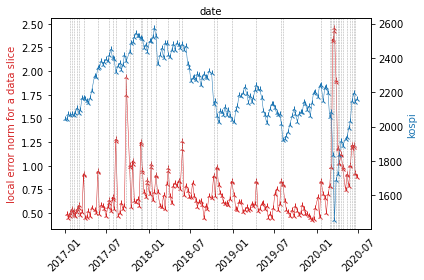

In [111]:
import matplotlib.pyplot as plt
def execute_online_tensor_decomposition(X_stream, rank=5, n_iter=1, ul=5, ll=3, verbose=False, methods=['onlinecp', 'transformed_onlinecp', 'dtd']):
    
    for method in methods:
        ktensors, verbose_list = online_tensor_decomposition(X_stream, rank, n_iter, ul, ll, verbose, method)
        X_est = construct_tensor(ktensors[0][1])
        for (weights, factors) in ktensors[1:]:
            X_est = tl.tensor(np.concatenate((X_est, construct_tensor(factors))))
        global_error_norm = compare_tensors(X, X_est)
        
    color = 'tab:red'
    fig, ax1 = plt.subplots()
    plt.xticks(rotation=45)
    ax1.set_ylabel('local error norm for a data slice', color=color)
    ax1.set_xlabel('date')
    ax1.xaxis.set_label_position('top')
    ax1.plot(index_data.date[verbose_list[:,0]*5], verbose_list[:,2], linewidth=0.5, marker="2", color=color)
    
    for p in refine_points:
        ax1.axvline(index_data.date[p*5],  label='line: {}'.format(p), c='darkgrey', linewidth=0.5, linestyle='--')
    for p in split_points:
        ax1.axvline(index_data.date[p*5],  label='line: {}'.format(p), c='darkgrey', linewidth=0.5)
        
    color = 'tab:blue'
    ax2 = ax1.twinx()
    ax2.plot(index_data.date[range(0, 855, 5)], index_data.ks11[range(0, 855, 5)], linewidth=0.5, marker="2", color=color)
    ax2.set_ylabel('kospi', color=color)
    fig.tight_layout()
    plt.savefig('results/{}{}-{}.png'.format(ul, ll, 'local_error_norm'), dpi=500)

X = stock_data
X_stream = create_tensor_stream(X, start_to_stream=5, batch_sizes=np.full((170), 5, dtype=int))

split_points = []
refine_points = []
execute_online_tensor_decomposition(X_stream, rank=3, n_iter=1, ul=-1, ll=0.7, verbose=False, methods=['onlinecp'])

### Load Stock Data

In [21]:
import pickle
with open('../Data/index_data.pkl', 'rb') as f:
    index_data = pickle.load(f)
    
index_data

,date,ks11
0,2017-01-03,2043.97
1,2017-01-04,2045.64
2,2017-01-05,2041.95
3,2017-01-06,2049.12
4,2017-01-09,2048.78
...,...,...
850,2020-06-24,2161.51
851,2020-06-25,2112.37
852,2020-06-26,2134.65
853,2020-06-29,2093.48


In [17]:
import csv

stock_data = tl.tensor(np.zeros([855, 189, 5], dtype='d'))
start = time.time()
with open('../Data/Stock_.tensor') as file:
    reader = csv.reader(file, delimiter='\t')    
    for row in reader:
        indices = np.asarray([index for index in np.int64(np.asarray(row[:-1]))])[[1, 0, 2]]
        stock_data[tuple(indices)] = np.double(row[-1])
print('>> stock_data loaded ', time.time() - start)

>> stock_data loaded  12.545601606369019
